In [1]:
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import DataLoader
from IPython.display import clear_output

In [2]:
SEED = 1
BATCH_SIZE = 32
LR = 0.00025
EPOCHS = 10
CLIP = 0.2
GAMMA = 0.999
LAMBDA = 0.98
ENT_COEF = 0.01
V_COEF = 1.0
V_CLIP = True
LIN_REDUCE = False
GRAD_NORM = False

# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
# np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

cuda: True


In [3]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()
        h = 64
        self.head = nn.Sequential(
            nn.Linear(obs_space, h),
            nn.Tanh()
        )
        self.pol = nn.Sequential(
            nn.Linear(h, h),
            nn.Tanh(),
            nn.Linear(h, action_space)
        )
        self.val = nn.Sequential(
            nn.Linear(h, h),
            nn.Tanh(),
            nn.Linear(h, 1)
        )
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        out = self.head(x)
        logit = self.pol(out).reshape(out.shape[0], -1)
        log_p = self.log_softmax(logit)
        v = self.val(out).reshape(out.shape[0], 1)

        return log_p, v

In [4]:
losses = []


def learn(net, old_net, train_memory):
    global CLIP, LR
    global total_epochs
    net.train()
    old_net.train()

    for epoch in range(EPOCHS):
        if LIN_REDUCE:
            lr = LR - (LR * epoch / total_epochs)
            clip = CLIP - (CLIP * epoch / total_epochs)
        else:
            lr = LR
            clip = CLIP
        dataloader = DataLoader(
            train_memory,
            shuffle=True,
            batch_size=BATCH_SIZE,
            pin_memory=use_cuda
        )
        optimizer = torch.optim.Adam(net.parameters(), lr=lr, eps=1e-5)

        for (s, a, ret, adv) in dataloader:
            s_batch = s.to(device).float()
            a_batch = a.to(device).long()
            ret_batch = ret.to(device).float()
            adv_batch = adv.to(device).float()
            adv_batch = (adv_batch - adv_batch.mean()) / (adv_batch.std() + 1e-5)
            with torch.no_grad():
                log_p_batch_old, v_batch_old = old_net(s_batch)
                log_p_acting_old = log_p_batch_old[range(BATCH_SIZE), a_batch]

            log_p_batch, v_batch = net(s_batch)
            log_p_acting = log_p_batch[range(BATCH_SIZE), a_batch]
            p_ratio = (log_p_acting - log_p_acting_old).exp()
            p_ratio_clip = torch.clamp(p_ratio, 1 - clip, 1 + clip)
            p_loss = torch.min(p_ratio * adv_batch,
                               p_ratio_clip * adv_batch).mean()
            if V_CLIP:
                v_clip = v_batch_old + \
                    torch.clamp(v_batch - v_batch_old, -clip, clip)
                v_loss1 = (ret_batch - v_clip).pow(2)
                v_loss2 = (ret_batch - v_batch).pow(2)
                v_loss = 0.5 * torch.max(v_loss1, v_loss2).mean()
            else:
                v_loss = 0.5 * (ret_batch - v_batch).pow(2).mean()

            log_p, _ = net(s_batch)
            entropy = -(log_p.exp() * log_p).sum(dim=1).mean()

            # loss
            loss = -(p_loss - V_COEF * v_loss + ENT_COEF * entropy)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            if GRAD_NORM:
                nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
            optimizer.step()
    train_memory.clear()


def get_action_and_value(obs, old_net):
    old_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p, v = old_net(state)
        m = Categorical(log_p.exp())
        action = m.sample()

    return action.item(), v.item()


def compute_adv_with_gae(rewards, values, roll_memory):
    rew = np.array(rewards, 'float')
    val = np.array(values[:-1], 'float')
    _val = np.array(values[1:], 'float')
    delta = rew + GAMMA * _val - val
    dis_r = np.array([GAMMA**(i) * r for i, r in enumerate(rewards)], 'float')
    gae_dt = np.array([(GAMMA * LAMBDA)**(i) * dt for i,
                       dt in enumerate(delta.tolist())], 'float')
    for i, data in enumerate(roll_memory):
        data.append(sum(dis_r[i:] / GAMMA**(i)))
        data.append(sum(gae_dt[i:] / (GAMMA * LAMBDA)**(i)))
    
    rewards.clear()
    values.clear()

    return roll_memory


def plot():
    clear_output(True)
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(ep_rewards, alpha=0.5)
    plt.subplot(121)
    plt.plot(reward_eval)
    plt.title(f'Reward: '
              f'{reward_eval[-1]}')
    plt.subplot(122)
    plt.plot(losses, alpha=0.5)
    plt.title(f'Loss: '
             f'{np.mean(list(reversed(losses))[: n_eval]).round(decimals=2)}')
    plt.show()

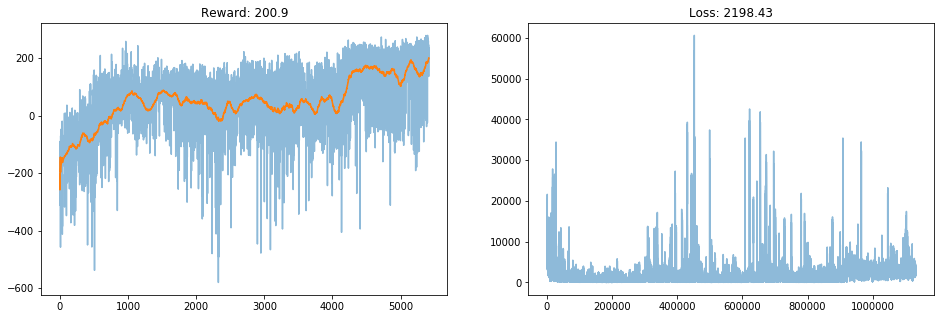


LunarLander-v2 is sloved! 5416 Episode in 3624078 steps


In [5]:
# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 100000
roll_len = 2048
total_epochs = roll_len // BATCH_SIZE
n_eval = env.spec.trials

# global values
steps = 0
ep_rewards = []
reward_eval =[]
is_rollout = False
is_solved = False

# make memories
train_memory = []
roll_memory = []
rewards = []
values = []

# make nerual networks
net = ActorCriticNet(obs_space, action_space).to(device)
old_net = deepcopy(net)


# play!
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        action, value = get_action_and_value(obs, old_net)
        _obs, reward, done, _ = env.step(action)

        # store
        roll_memory.append([obs, action])
        rewards.append(reward)
        values.append(value)

        obs = _obs
        steps += 1
        ep_reward += reward

        if done or steps % roll_len == 0:
            if done:
                _value = 0.
            else:
                _, _value = get_action_and_value(_obs, old_net)

            values.append(_value)
            train_memory.extend(compute_adv_with_gae(
                rewards, values, roll_memory))
            roll_memory.clear()

        if steps % roll_len == 0:
            learn(net, old_net, train_memory)
            old_net.load_state_dict(net.state_dict())

    if done:
        ep_rewards.append(ep_reward)
        reward_eval.append(
            np.mean(list(reversed(ep_rewards))[: n_eval]).round(decimals=2))
        plot()
#         print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
#             i, steps, ep_reward))

        if len(ep_rewards) >= n_eval:
            if reward_eval[-1] >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, steps))
                torch.save(net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_ppo_st.pt')
                break
env.close()

In [6]:
[
    ('CartPole-v0', 1229, 2048, 0.2, 10, 1.0, 0.01, False, 0.999, 0.98),
    ('CartPole-v1', 1237, 2048, 0.2, 10, 1.0, 0.01, False, 0.999, 0.98),
    ('MountainCar-v0', None),
    ('LunarLander-v2', 5416, 2048, 0.2, 10, 1.0, 0.01, False, 0.999, 0.98)
]

[('CartPole-v0', 1229, 2048, 0.2, 10, 1.0, 0.01, False, 0.999, 0.98),
 ('CartPole-v1', 1237, 2048, 0.2, 10, 1.0, 0.01, False, 0.999, 0.98),
 ('MountainCar-v0', None),
 ('LunarLander-v2', 5416, 2048, 0.2, 10, 1.0, 0.01, False, 0.999, 0.98)]